<a href="https://colab.research.google.com/github/smcck222/U-Net-CNN-for-Crack-Segmentation/blob/main/Crack_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### U-NET CNN for Crack Detection and Segmentation.

### Loading Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2
path="/content/drive/My Drive/crack_segmentation_dataset_edited"

In [ ]:
load_images_from_folder(path)

In [ ]:
img=cv2.imread(path)

In [ ]:
img.shape

(448, 448, 3)

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        '''image_path ="/content/drive/My Drive/crack_segmentation_dataset.zip (Unzipped Files)/crack_segmentation_dataset/crack_segmentation_dataset/train/images/"''' 
        #os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        ''''mask_path = "/content/drive/My Drive/crack_segmentation_dataset.zip (Unzipped Files)/crack_segmentation_dataset/crack_segmentation_dataset/train/masks/"'''
        image_path=self.path+"/images/"+id_name
        #os.path.join(self.path, id_name, "masks/")
        #all_masks = os.listdir(mask_path)
        #image_path+=id_name
        #print(image_path)
        mask_path=self.path+"/masks/"+id_name
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.imread(mask_path, -1)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask=np.expand_dims(mask, axis=-1)
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image,mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
import math
image_size = 128
train_path = "/content/drive/My Drive/crack_segmentation_dataset_edited/train/images"
epochs = 25
batch_size = 8

## Training Ids
#train_ids = next(os.walk(train_path))
train_ids=os.listdir(train_path)
## Validation Data Size
val_data_size = math.ceil(0.1*len(train_ids))

val_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
#len(train_ids)
#len(val_ids)
#train_ids[0:60]

In [ ]:

train_path = "/content/drive/My Drive/crack_segmentation_dataset_edited/train/"
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)
#gen.ids
#gen.path
#train_ids

(8, 128, 128, 3) (8, 128, 128, 1)


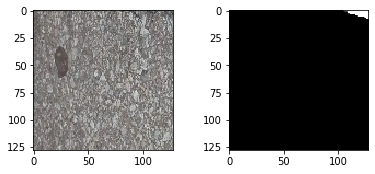

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")


### Building the U-Net

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c



In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

### Training Phase

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(val_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(val_ids)//batch_size

In [ ]:
x, y = valid_gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


In [ ]:

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=25)

Epoch 1/25
1080/1080 [==============================] - 5649s 5s/step - loss: 0.1155 - acc: 0.9519 - val_loss: 0.1178 - val_acc: 0.9535
Epoch 2/25
1080/1080 [==============================] - 491s 455ms/step - loss: 0.1021 - acc: 0.9538 - val_loss: 0.0832 - val_acc: 0.9559
Epoch 3/25
1080/1080 [==============================] - 489s 453ms/step - loss: 0.0902 - acc: 0.9555 - val_loss: 0.0817 - val_acc: 0.9540
Epoch 4/25
1080/1080 [==============================] - 500s 463ms/step - loss: 0.0861 - acc: 0.9561 - val_loss: 0.0818 - val_acc: 0.9569
Epoch 5/25
1080/1080 [==============================] - 502s 464ms/step - loss: 0.0828 - acc: 0.9570 - val_loss: 0.0708 - val_acc: 0.9581
Epoch 6/25
1080/1080 [==============================] - 505s 468ms/step - loss: 0.0800 - acc: 0.9573 - val_loss: 0.0664 - val_acc: 0.9598
Epoch 7/25
1080/1080 [==============================] - 501s 464ms/step - loss: 0.0757 - acc: 0.9584 - val_loss: 0.0624 - val_acc: 0.9605
Epoch 8/25
1080/1080 [==============

In [ ]:
## Save the Weights
#model.save_weights("UNetW_25epoch.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(10)
result = model.predict(x)

result = result > 0.5

In [ ]:
y.shape

(1, 128, 128, 1)

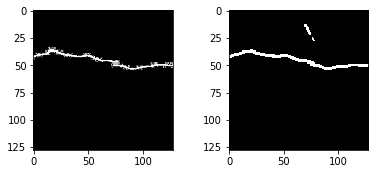

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

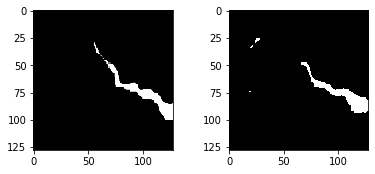

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

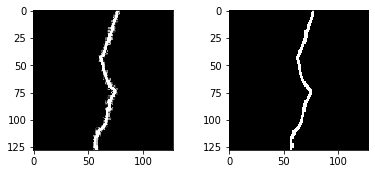

In [ ]:
###7
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

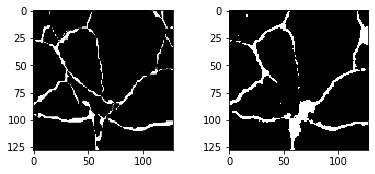

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

### Testing Phase

In [ ]:
##    test data
#import math
#image_size = 128
#train_path = "/content/drive/My Drive/crack_segmentation_dataset_edited/train/images"
#epochs = 25
#batch_size = 8

## Training Ids
#train_ids = next(os.walk(train_path))
#train_ids=os.listdir(train_path)
## Validation Data Size
#val_data_size = math.ceil(0.1*len(train_ids))

#val_ids = train_ids[:val_data_size]
#train_ids = train_ids[val_data_size:]
#len(train_ids)
#len(val_ids)
#train_ids[0:60
test_path = "/content/drive/My Drive/crack_segmentation_dataset_edited/test/"
test_ids=os.listdir(test_path+"/images")
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)


In [ ]:
# 7 or 4
x, y = test_gen.__getitem__(6)
result = model.predict(x)

result = result > 0.5


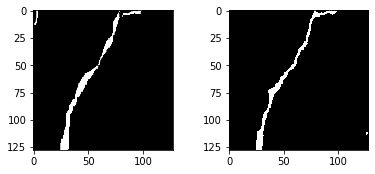

In [ ]:
# getitem(10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")

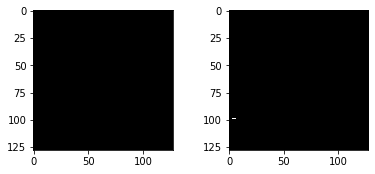

In [ ]:
# getitem(10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")

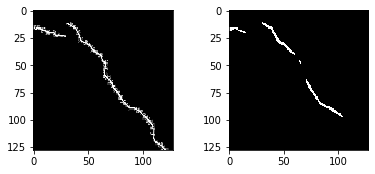

In [ ]:
# getitem(10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

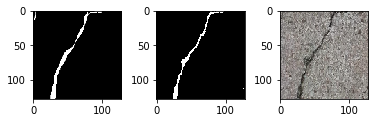

In [ ]:
## BLUE!!!!!!!!!!!
x, y = test_gen.__getitem__(10)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


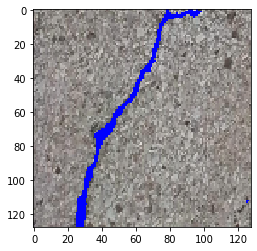

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
plt.imshow(new_img)

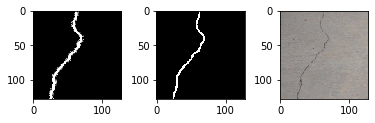

In [ ]:
x, y = test_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


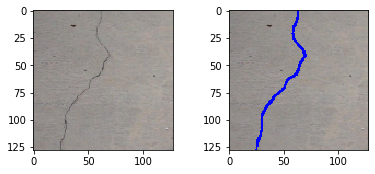

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[0]
mask=np.reshape(result[0]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)


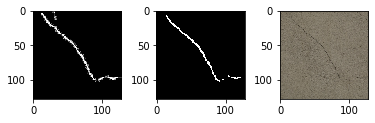

In [ ]:
x, y = test_gen.__getitem__(4)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


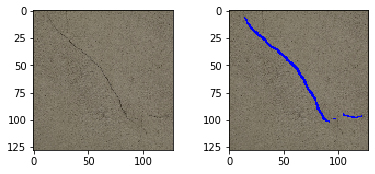

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

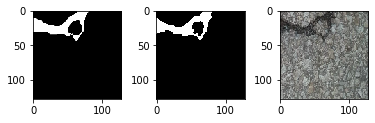

In [ ]:
x, y = test_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


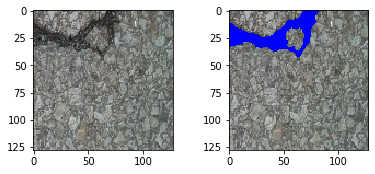

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[0]
mask=np.reshape(result[0]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

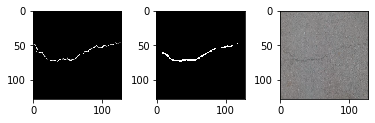

In [ ]:
x, y = test_gen.__getitem__(11)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[1])
#for i in range(len(test_gen.ids)):
 # if 'CFD' in test_gen.ids[i]:
  #  print(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


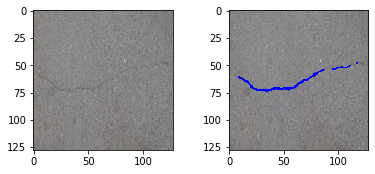

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[1]
mask=np.reshape(result[1]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

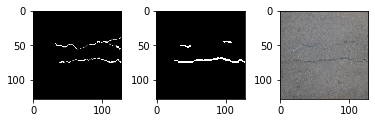

In [ ]:
x, y = test_gen.__getitem__(128)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])
#for i in range(len(test_gen.ids)):
 # if 'CFD' in test_gen.ids[i]:
  #  print(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


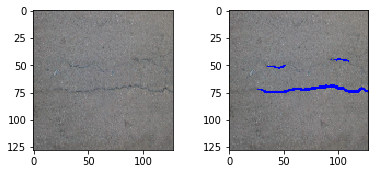

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

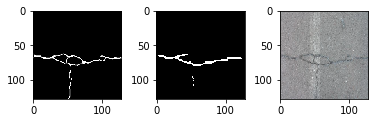

In [ ]:
x, y = test_gen.__getitem__(89)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])





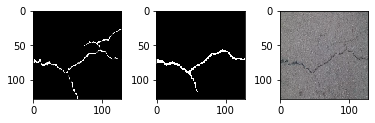

In [ ]:
x, y = test_gen.__getitem__(155)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[5]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[5]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[5])





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


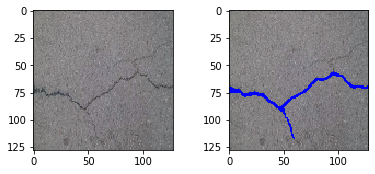

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[5]
mask=np.reshape(result[5]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


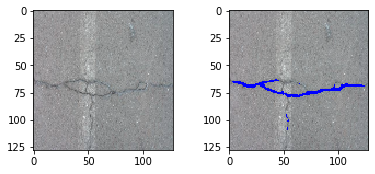

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


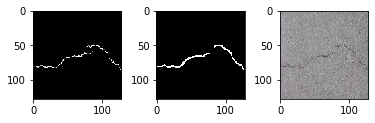

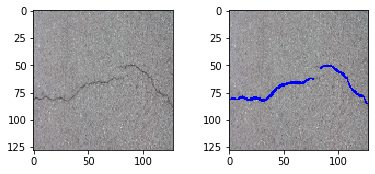

In [ ]:
x, y = test_gen.__getitem__(131)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[7]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[7]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[7])



import cv2
import cv2 as cv
import numpy as np
img_original=x[7]
mask=np.reshape(result[7]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
#https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


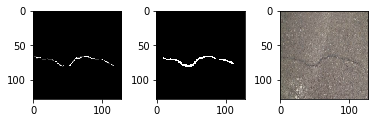

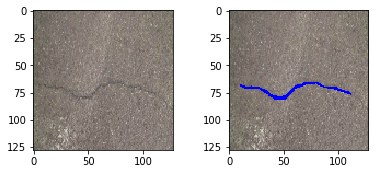

In [ ]:
x, y = test_gen.__getitem__(199)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[5]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[5]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[5])



import cv2
import cv2 as cv
import numpy as np
img_original=x[5]
mask=np.reshape(result[5]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


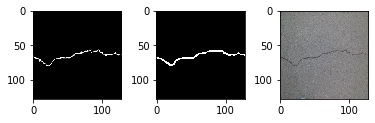

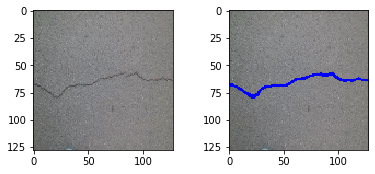

In [ ]:
x, y = test_gen.__getitem__(200)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[3]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[3]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[3])



import cv2
import cv2 as cv
import numpy as np
img_original=x[3]
mask=np.reshape(result[3]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


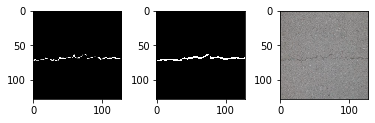

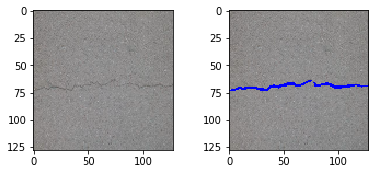

In [ ]:
x, y = test_gen.__getitem__(203)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[0])



import cv2
import cv2 as cv
import numpy as np
img_original=x[0]
mask=np.reshape(result[0]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
len(valid_gen.ids)

961

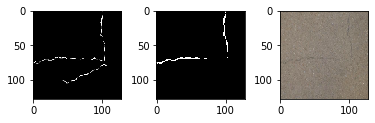

In [ ]:
x, y = test_gen.__getitem__(204)
result = model.predict(x)

result = result > 0.5
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y[3]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[3]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 3, 3)
ax.imshow(x[3])





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


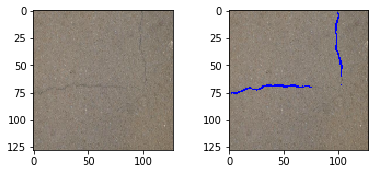

In [ ]:
import cv2
import cv2 as cv
import numpy as np
img_original=x[3]
mask=np.reshape(result[3]*255, (image_size, image_size))
mask.shape
#mask_ex=np.expand_dims(mask,axis=-1)
#mask_rgb=cv2.cvtColor(mask_ex,cv2.COLOR_GRAY2RGB)
#cv2.add(mask,img_original)
#mask.dtype
mask.shape
mask8=np.array(mask,dtype=np.uint8)
mask8.shape
mask_rgb=cv2.cvtColor(mask8,cv2.COLOR_GRAY2RGB)
#im=cv2.bitwise_and(mask_rgb,img_original,mask=mask_rgb)
#plt.imshow()
#mask_rgb.shape
#.shape
blue=np.array([0,0,255])
new_img=(img_original+mask_rgb)
'''for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      #img[i][j]=blue
plt.imshow(new_img)'''
#np.where(new_img>255)
new_img[new_img>255]=255     
#plt.imshow(new_img)
for i in range(0,new_img.shape[0]):
  for j in range(0,new_img.shape[0]):
    if(all(new_img[i][j]==255)):
      #print('entered')
      new_img[i][j]=blue
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_original)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(new_img)

In [ ]:
import math
image_size = 128
test_path = "/content/drive/My Drive/Datasets/crack_segmentation_dataset_edited/test/images"
epochs = 25
batch_size = 8

## Testing ids.
test_ids=os.listdir(test_path)

actual_mask = [] 
predicted_mask = [] 

test_path = "/content/drive/My Drive/Datasets/crack_segmentation_dataset_edited/test/"
test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)

test_steps = len(test_ids)//batch_size

In [1]:
x, y = test_gen.__getitem__(0)
print(x.shape, y.shape)

result = model.predict(x)

result = result > 0.5

(8, 128, 128, 3) (8, 128, 128, 1)


In [2]:
model.evaluate_generator(test_gen, steps=test_steps, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

# https://keras.io/models/model/

[0.06988927812019796, 0.8077124, 0.462861])
